# Visualizing Earnings Based on College Majors

Choosing a college major is a big life choice. A college degree has big implications for student's future career, economic, and life opportunities.

For the past 3 years, I've helped high school students navigate the college finance process. I've spent a lot of time helping students understand and compare the financial implications of attending different colleges. I've appreciated that a student's choice of major will have a big impact on the "economic return" that they experience from their college investment. I'm interested to explore how students' choice of major affects earnings opportunities after college.

In this analysis, I'll investigate:
- What majors lead to the greatest earnings? How are earnings different across majors?
- What college majors experience higher or lower levels of employment?
- How do Men and Women pursue majors differently and how does this affect their earnings?

The data analyzed here is originally from the US Census's 2010- 2012 American Community Survey. It has been made available in a cleaned form by fivetthirtyeight. https://github.com/fivethirtyeight/data/tree/master/college-majors 

In [20]:
import pandas as pd
import pandas.plotting as pp
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline

recent_grads = pd.read_csv('recent-grads.csv')

## Getting familiar with the data

Let's start by taking a look at the fields we're working with and by looking at some example data. Below are the definitions of each field.

- Rank - Rank by median earnings (the dataset is ordered by this column).
- Major_code - Major code.
- Major - Major description.
- Major_category - Category of major.
- Total - Total number of people with major.
- Sample_size - Sample size (unweighted) of full-time.
- Men - Male graduates.
- Women - Female graduates.
- ShareWomen - Women as share of total.
- Employed - Number employed.
- Median - Median salary of full-time, year-round workers.
- Low_wage_jobs - Number in low-wage service jobs.
- Full_time - Number employed 35 hours or more.
- Part_time - Number employed less than 35 hours.


In [2]:
print(recent_grads.info())
print('\n')
recent_grads.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 21 columns):
Rank                    173 non-null int64
Major_code              173 non-null int64
Major                   173 non-null object
Total                   172 non-null float64
Men                     172 non-null float64
Women                   172 non-null float64
Major_category          173 non-null object
ShareWomen              172 non-null float64
Sample_size             173 non-null int64
Employed                173 non-null int64
Full_time               173 non-null int64
Part_time               173 non-null int64
Full_time_year_round    173 non-null int64
Unemployed              173 non-null int64
Unemployment_rate       173 non-null float64
Median                  173 non-null int64
P25th                   173 non-null int64
P75th                   173 non-null int64
College_jobs            173 non-null int64
Non_college_jobs        173 non-null int64
Low_wage_jobs          

,Rank,Major_code,Major,Total,Men,Women,Major_category,ShareWomen,Sample_size,Employed,Full_time,Part_time,Full_time_year_round,Unemployed,Unemployment_rate,Median,P25th,P75th,College_jobs,Non_college_jobs,Low_wage_jobs
0,1,2419,PETROLEUM ENGINEERING,2339.0,2057.0,282.0,Engineering,0.120564,36,1976,1849,270,1207,37,0.018381,110000,95000,125000,1534,364,193
1,2,2416,MINING AND MINERAL ENGINEERING,756.0,679.0,77.0,Engineering,0.101852,7,640,556,170,388,85,0.117241,75000,55000,90000,350,257,50
2,3,2415,METALLURGICAL ENGINEERING,856.0,725.0,131.0,Engineering,0.153037,3,648,558,133,340,16,0.024096,73000,50000,105000,456,176,0
3,4,2417,NAVAL ARCHITECTURE AND MARINE ENGINEERING,1258.0,1123.0,135.0,Engineering,0.107313,16,758,1069,150,692,40,0.050125,70000,43000,80000,529,102,0
4,5,2405,CHEMICAL ENGINEERING,32260.0,21239.0,11021.0,Engineering,0.341631,289,25694,23170,5180,16697,1672,0.061098,65000,50000,75000,18314,4440,972


In [3]:
# There are three columns that are missing one value. 
# There is one row that's responsible for all the nulls - Food Science.
# We'll drop that row so that the rest of our data is complete.

recent_grads = recent_grads.dropna(axis=0)

In [4]:
# This confirms that we have 172 records with no null values.

recent_grads.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 0 to 172
Data columns (total 21 columns):
Rank                    172 non-null int64
Major_code              172 non-null int64
Major                   172 non-null object
Total                   172 non-null float64
Men                     172 non-null float64
Women                   172 non-null float64
Major_category          172 non-null object
ShareWomen              172 non-null float64
Sample_size             172 non-null int64
Employed                172 non-null int64
Full_time               172 non-null int64
Part_time               172 non-null int64
Full_time_year_round    172 non-null int64
Unemployed              172 non-null int64
Unemployment_rate       172 non-null float64
Median                  172 non-null int64
P25th                   172 non-null int64
P75th                   172 non-null int64
College_jobs            172 non-null int64
Non_college_jobs        172 non-null int64
Low_wage_jobs          

## What's the range of earnings across majors?

count        172
mean      40,077
std       11,461
min       22,000
25%       33,000
50%       36,000
75%       45,000
max      110,000
Name: Median, dtype: object

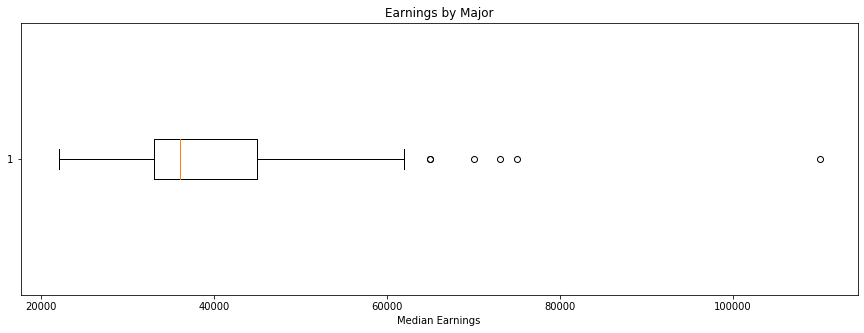

In [5]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
ax.boxplot(recent_grads['Median'],vert=False)

plt.xlabel('Median Earnings')
plt.title('Earnings by Major')

desc_1 = recent_grads['Median'].describe(include='all')
desc_1 = desc_1.apply('{:,.0f}'.format)
desc_1


We can start with a few important observations. 

1) There's a pretty big earnings range. While the core of students make between 33k and 45k, some students made as low as 22k, and some as high as 110k. The top major is earning 5 times more than the bottom major.

2) There are a few majors that earn a lot more than the rest.


# What majors lead to the highest earnings?

In [6]:
#Let's look at all of the majors that are in the top quartile of earnings

recent_grads.loc[recent_grads['Median'] > 45000,'Major']

0                                 PETROLEUM ENGINEERING
1                        MINING AND MINERAL ENGINEERING
2                             METALLURGICAL ENGINEERING
3             NAVAL ARCHITECTURE AND MARINE ENGINEERING
4                                  CHEMICAL ENGINEERING
5                                   NUCLEAR ENGINEERING
6                                     ACTUARIAL SCIENCE
7                            ASTRONOMY AND ASTROPHYSICS
8                                MECHANICAL ENGINEERING
9                                ELECTRICAL ENGINEERING
10                                 COMPUTER ENGINEERING
11                                AEROSPACE ENGINEERING
12                               BIOMEDICAL ENGINEERING
13                                    MATERIALS SCIENCE
14            ENGINEERING MECHANICS PHYSICS AND SCIENCE
15                               BIOLOGICAL ENGINEERING
16             INDUSTRIAL AND MANUFACTURING ENGINEERING
17                                  GENERAL ENGI

It looks like engineering is heavily represented in the best paid majors. Non-engineering majors on the top list include Actuarial Science, Court Reporting, Construction Services, Operations Logistics and E-Commerce, Public policy, nursing, finances, economics, and very interestingly miscellaneous fine arts.

If you're a college student looking to make a lot of money, maybe find a type of engineering that interests you.

## What are earnings differences by major category? 

In [7]:
# What are the different major categories?

recent_grads['Major_category'].unique()

array(['Engineering', 'Business', 'Physical Sciences',
       'Law & Public Policy', 'Computers & Mathematics',
       'Industrial Arts & Consumer Services', 'Arts', 'Health',
       'Social Science', 'Biology & Life Science', 'Education',
       'Agriculture & Natural Resources', 'Humanities & Liberal Arts',
       'Psychology & Social Work', 'Communications & Journalism',
       'Interdisciplinary'], dtype=object)

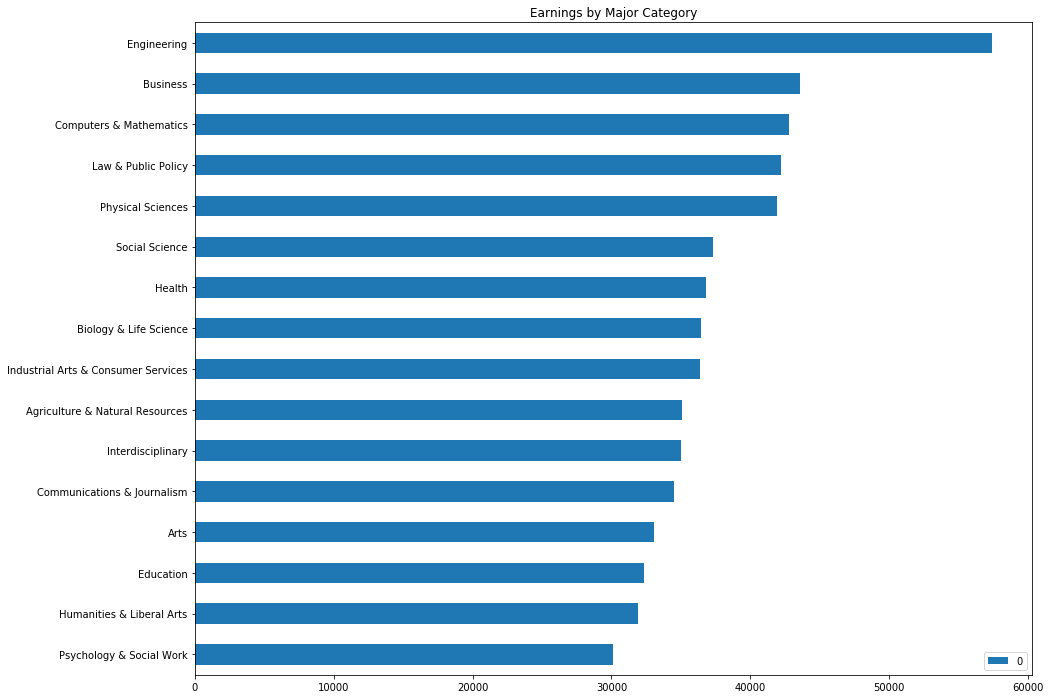

In [8]:
# Lets create a chart with the average earnings for each major category.

major_categories = recent_grads['Major_category'].unique()

earnings_category = {}

for m in major_categories:
    avg_earn = recent_grads.loc[recent_grads['Major_category'] == m,'Median'].mean()
    earnings_category[m] = avg_earn
    
earnings_c = pd.DataFrame.from_dict(earnings_category, orient='index')

earnings_c = earnings_c.sort_values(0, ascending = True)

earnings_c.plot(kind='barh', title='Earnings by Major Category', figsize=(15,12))
plt.show()


Again, we see that engineering is the top rated major category. Business, computers & math, law & public policy, and physcial science also rank highly.

Arts, Education, Humanities & Liberal Arts, Psychology and Social Work are among the least compensated majors.

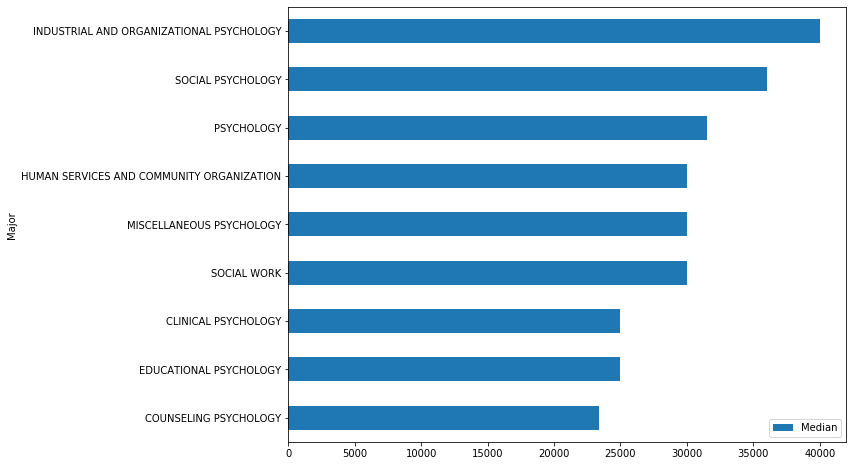

In [19]:
# Create a tool to explore earnings by major within each major category

major_cat = 'Psychology & Social Work'

selected_rows = recent_grads[recent_grads['Major_category'] == major_cat]

selected_sorted = selected_rows.sort_values('Median',ascending=True)

selected_sorted[['Major','Median']].plot.barh(x='Major',y='Median',figsize=(10,8))
plt.show()

## Are students more likely to pursue majors that make more money?

As money is probably a common aspect of students' choice of major, we might expect that the most popular majors are the ones that make the most money. Is this the case?

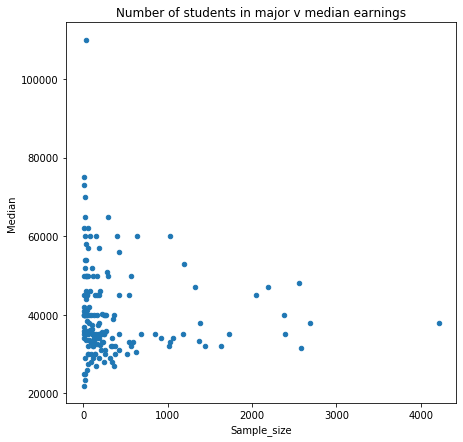

The correlation is: -0.06


In [10]:
recent_grads.plot(x='Sample_size', y='Median', kind='scatter', title='Number of students in major v median earnings', figsize=(7,7))
plt.show()

c,p = pearsonr(recent_grads['Sample_size'],recent_grads['Median'])
print('The correlation is: {:.2f}'.format(c))

Interesting! There is actually a slight negative correlation between popular majors and high paying majors. 

The most lucrative majors have a relatively small number of students.

Maybe when students are selecting their majors, they don't have good information about earnings potential. Or maybe most students don't prioritize earnings when selecting a major. Or maybe there are barriers to entering the highest paid majors, like high academic requirements to join an engineering program or a challenging requirements during the program.

# What majors experience higher or lower levels of employment?

## What's the link between majors that have more grads working full time and earnings?


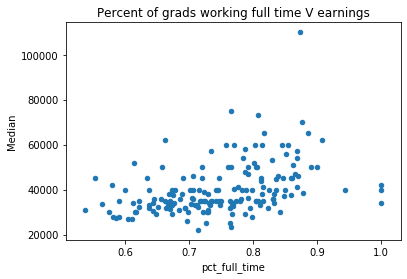

The correlation is: 0.41


In [11]:
#First, let's confirm that 'Full_Time' and "Part_Time" sum to Total

rg2=recent_grads.copy()
rg2['pct_full_time'] = rg2['Full_time'] / (rg2['Full_time'] + rg2['Part_time'])


# Now let's look at a scatter plot that compares percent of employed graduates working full time
# against median earnings for the major.
# I'd expect that majors with a higher percent of grads working full time would have higher earnings.

rg2.plot(x='pct_full_time', y='Median', kind='scatter', title='Percent of grads working full time V earnings')
plt.show()

c3,p3 = pearsonr(rg2['pct_full_time'],rg2['Median'])
print('The correlation is: {:.2f}'.format(c3))

As we might expect, majors with more graduates working full time tend to earn higher incomes. This makes sense because they should be compensated for their additional time on the job. 

## Unemployment in the highest v lowest paid majors

Surpisingly unemployment falls in similar ranges for higher and lower paid majors. 

For higher paid majors, mining and mineral engineering has a much higher unemployment rate than others. 

For lower paid majorsc clinical psychology and library science have higher unemployment than other majors. 

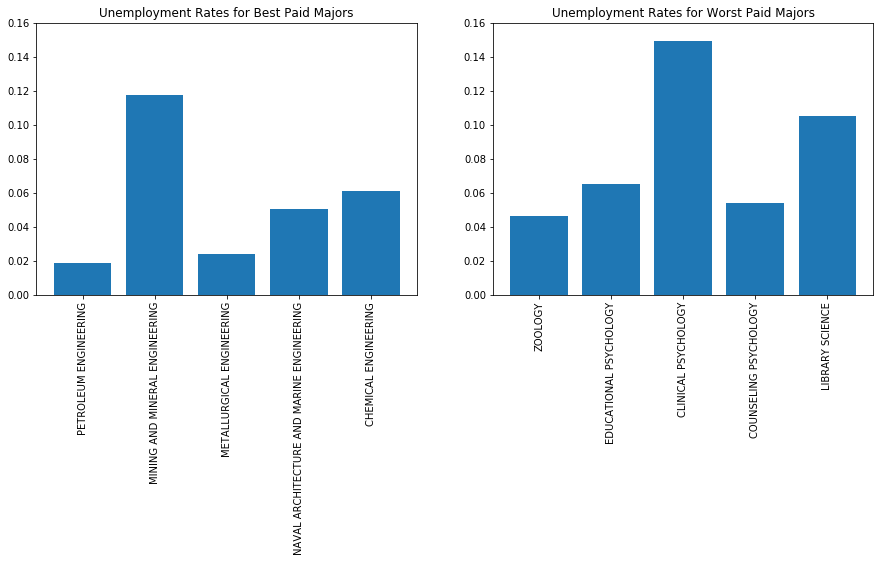

In [65]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

b_space = np.arange(5)+.75
top_paid = recent_grads.loc[:4,'Unemployment_rate']
lowest_paid = recent_grads.loc[168:,'Unemployment_rate']
top_labels = recent_grads.loc[:4,'Major']
lowest_labels = recent_grads.loc[168:,'Major']

ax1.bar(b_space,top_paid)
ax2.bar(b_space,lowest_paid)

ax1.set_xticks(b_space)
ax2.set_xticks(b_space)

ax1.set_xticklabels(top_labels, rotation=90)
ax2.set_xticklabels(lowest_labels, rotation=90)

ax1.set_title('Unemployment Rates for Best Paid Majors')
ax2.set_title('Unemployment Rates for Worst Paid Majors')

ax1.set_ylim(0,.16)
ax2.set_ylim(0,.16)

plt.show()

#recent_grads[:5].plot.bar(x='Major', y='Unemployment_rate')
#recent_grads[167:].plot.bar(x='Major', y='Unemployment_rate')

1) Use a grouped bar plot to compare the number of men with the number of women in each category of majors.

2) Use a box plot to explore the distributions of median salaries and unemployment rate.

3) Use a hexagonal bin plot to visualize the columns that had dense scatter plots from earlier in the project.

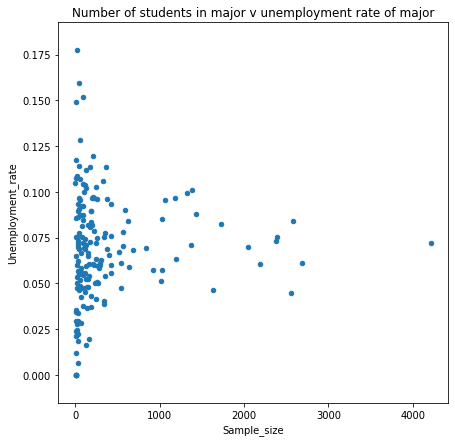

The correlation is: 0.06


In [13]:
# Are students more likely to pursue majors that have lower rates of unemployment?

recent_grads.plot(x='Sample_size', y='Unemployment_rate', kind='scatter', title='Number of students in major v unemployment rate of major', figsize=(7,7))
plt.show()

c1,p1 = pearsonr(recent_grads['Sample_size'],recent_grads['Unemployment_rate'])
print('The correlation is: {:.2f}'.format(c1))

There's a mediumly strong positive relationship between the popularity of a major and higher unemployment rates. Maybe students are not intentionally pursuing majors that lead to consistent employment opportunities. 

Maybe when students are selecting their major they're not thinking too much about the employment rate of their future job opportunies, or maybe they don't have that information, or maybe the specific job they'll go into isn't yet clear, making it seem hard to predict their future employment rate.

# How do men and women pursue majors differently?

## What percent of majors are majority male?

In [14]:
majority_men = recent_grads[recent_grads['ShareWomen'] < .5]
majority_women = recent_grads[recent_grads['ShareWomen'] > .5]

percent_predom_men=(len(majority_men)/(len(majority_men)+len(majority_women)))*100
percent_predom_women=100-percent_predom_men

print('{:.2f}% of majors have a majority of male students'.format(percent_predom_men))
print('{:.2f}% of majors have a majority of female students'.format(percent_predom_women))

44.19% of majors have a majority of male students
55.81% of majors have a majority of female students


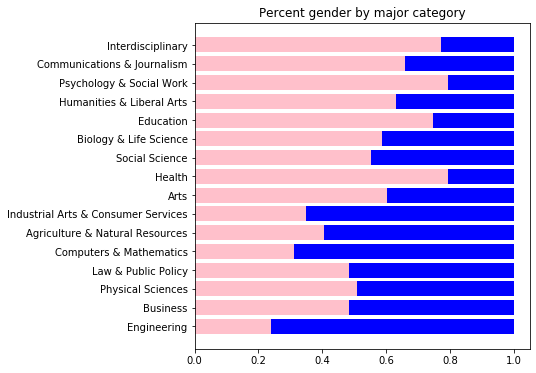

In [104]:
#First I'll make a data frame for  a table where the rows are major category and the columns are percent men and percent women. 
maj_cats = recent_grads['Major_category'].unique()
women_by_cat = {}
men_by_cat = {}

for m in maj_cats:
    mc_women = recent_grads.loc[recent_grads['Major_category'] == m,'ShareWomen'].mean()
    women_by_cat[m] = mc_women
    
for m in women_by_cat:
    mc_men = 1 - women_by_cat[m]
    men_by_cat[m] = mc_men

women_df = pd.DataFrame.from_dict(women_by_cat,orient='index')
men_df = pd.DataFrame.from_dict(men_by_cat,orient='index')

#Then make a bar chart in which every bar is a major category and the height is the percentage of a gender in that category.

ind = np.arange(16)+.75

f = plt.figure(figsize=(6,6))
a = f.add_subplot()

a.barh(ind, women_df[0], color='pink')
a.barh(ind, men_df[0], left=women_df[0], color='blue')

#Then make it look nice

a.set_title('Percent gender by major category')
a.set_yticks(ind)
a.set_yticklabels(maj_cats)



plt.show()

## How do earnings change by gender composition of major?

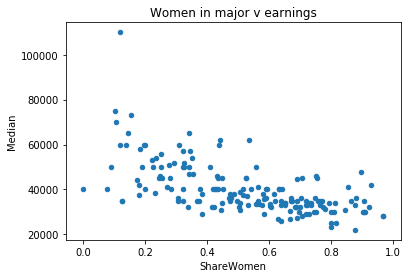

The correlation is: -0.62


In [15]:
recent_grads.plot(x='ShareWomen', y='Median', kind='scatter', title='Women in major v earnings')
plt.show()

c2,p2 = pearsonr(recent_grads['ShareWomen'],recent_grads['Median'])
print('The correlation is: {:.2f}'.format(c2))

There is a negative relationship between the percent of women in a major and the median eranings of that major.

Perhaps this data is representing that:
- Women are paid less than men for comparable work
- Women may be encouraged to pursue less prestigous careers
- Women may have more family responsibilities which can compete with work priorities

## How many women are in the higest and lowest paying majors?

As we might expect the highest paid majors have pretty low levels of women. Out of highly paid majors, chemical engineering has more women than others. 

The lowest paid 5 majors has much higher representation of Women.

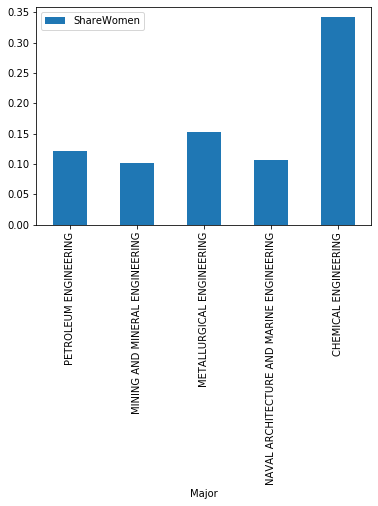

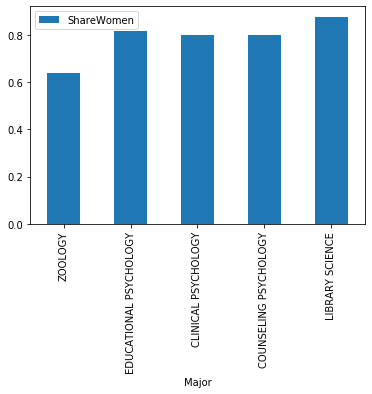

In [16]:
recent_grads[:5].plot.bar(x='Major', y='ShareWomen')
plt.show()
recent_grads[167:].plot.bar(x='Major', y='ShareWomen')
plt.show()

## How many people are in our sample for each major?

count     172.000000
mean      357.941860
std       619.680419
min         2.000000
25%        42.000000
50%       131.000000
75%       339.000000
max      4212.000000
Name: Sample_size, dtype: float64

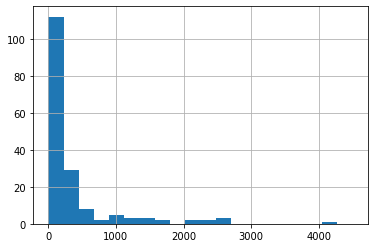

In [17]:
recent_grads['Sample_size'].hist(bins=20, range=(0,4500))
recent_grads['Sample_size'].describe(include='all')

For most majors, there are fewer than about 200 people in the data set. Though we do have a few majors with thousands of people represented. 

## Whats the relationship between number of students in major, median earnings, and unemployment rate?

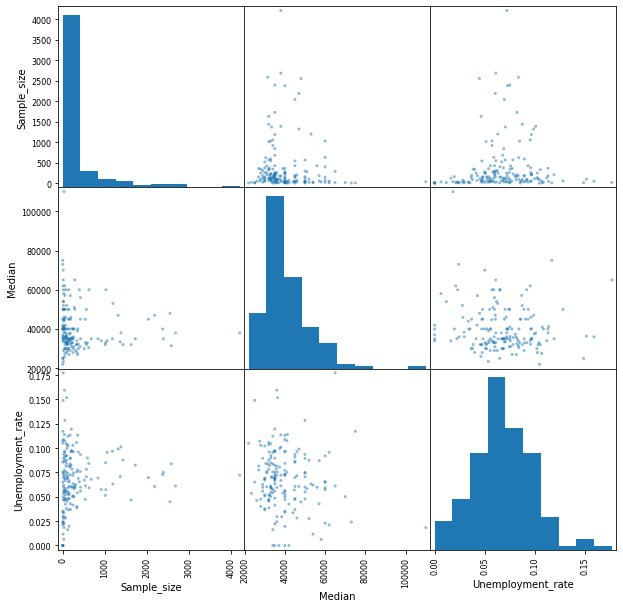

In [18]:
pp.scatter_matrix(recent_grads[['Sample_size','Median','Unemployment_rate']],figsize=(10,10))
plt.show()

One new interesting piece of information here is the relationship between unemployment rate and median earnings. We might expect to see a negative relationship - as median earnings increases maybe unemployment should decrease. Perhaps that would be because majors that lead to high paying jobs also lead to jobs that have a high number of openings. But we don't really see that. Seems like high paid majors don't necessarily have a higher or lower likelihood of being unemployeed.

# Conclusion 

In my professional work, I've seen that high school and college students often lack an understanding about what career opportunities could be available for graduates of different majors. For students in vulnerable financial situations, like those with large amounts of student debt, this can be a big problem. 

I'm interested to provide high school and early college students with better ways to explore career options and make a college major decision that incorporates good information on earnings opportunities.

I'd like to continue to work with data on this topic, especially by designing easy-to-use outputs of this analysis that can be explored by students themselves.

I'd like to improve on this analysis by: 
- Using more up to date data.
- Incorporating data on earnings differences by college institution. Eventually I think it would be really powerful to create a tool that could help a student answer the question, "what earnings could I expect if I get a degree in X topic from Y university?"